In [258]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [259]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

In [260]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [261]:
def polarity_scores_roberta(text):
    labels = [-1, 0, 1]
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    i, = np.where(scores == scores.max())
    return scores_dict, labels[i[0]]

## Bitcoin

In [262]:
btc_df = pd.read_csv(f'BTC_Tweets.csv', index_col=0)

In [263]:
btc_df.head()

,Date,Retweet,Reply,Likes,Tweet
0,2020-07-01 08:25:58+00:00,694,165,3022,#Bitcoin S2F chart update .. RED DOT #2 🔴 http...
1,2020-07-01 01:32:23+00:00,301,122,2875,Bitcoin will soon do to banks what email did t...
2,2020-07-01 23:00:05+00:00,318,43,2098,💻 Two new teasers have dropped in #ApexLegends...
3,2020-07-01 17:01:32+00:00,172,148,1714,10 bitcoin to be a billionaire.
4,2020-07-01 12:33:03+00:00,2195,917,1681,I will give someone $150 in 24hours all you ha...


In [264]:
roberta_result = {}
classes = []
for i, row in tqdm(btc_df.iterrows(), total=len(btc_df)):
    text = row['Tweet']
    result = polarity_scores_roberta(text)
    roberta_result[i] = {**result[0]}
    classes.append(result[1])

100%|██████████| 6081/6081 [11:05<00:00,  9.14it/s]


In [265]:
btc_df = btc_df.join(pd.DataFrame(roberta_result).T)
btc_df['classes'] = classes

btc_df.head()

,Date,Retweet,Reply,Likes,Tweet,roberta_neg,roberta_neu,roberta_pos,classes
0,2020-07-01 08:25:58+00:00,694,165,3022,#Bitcoin S2F chart update .. RED DOT #2 🔴 http...,0.020831,0.904005,0.075164,0
1,2020-07-01 01:32:23+00:00,301,122,2875,Bitcoin will soon do to banks what email did t...,0.033729,0.592106,0.374165,0
2,2020-07-01 23:00:05+00:00,318,43,2098,💻 Two new teasers have dropped in #ApexLegends...,0.091743,0.844816,0.063441,0
3,2020-07-01 17:01:32+00:00,172,148,1714,10 bitcoin to be a billionaire.,0.029795,0.782686,0.187519,0
4,2020-07-01 12:33:03+00:00,2195,917,1681,I will give someone $150 in 24hours all you ha...,0.001092,0.040329,0.958579,1


In [266]:
btc_df.to_csv('sentiment_btc.csv')

In [267]:
btc_df['Date'] = pd.to_datetime(btc_df['Date']).dt.date
btc_df1 = btc_df.groupby('Date')[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()

In [268]:
dff = pd.read_csv(r'BTC_tweet_perday.csv', index_col=0)

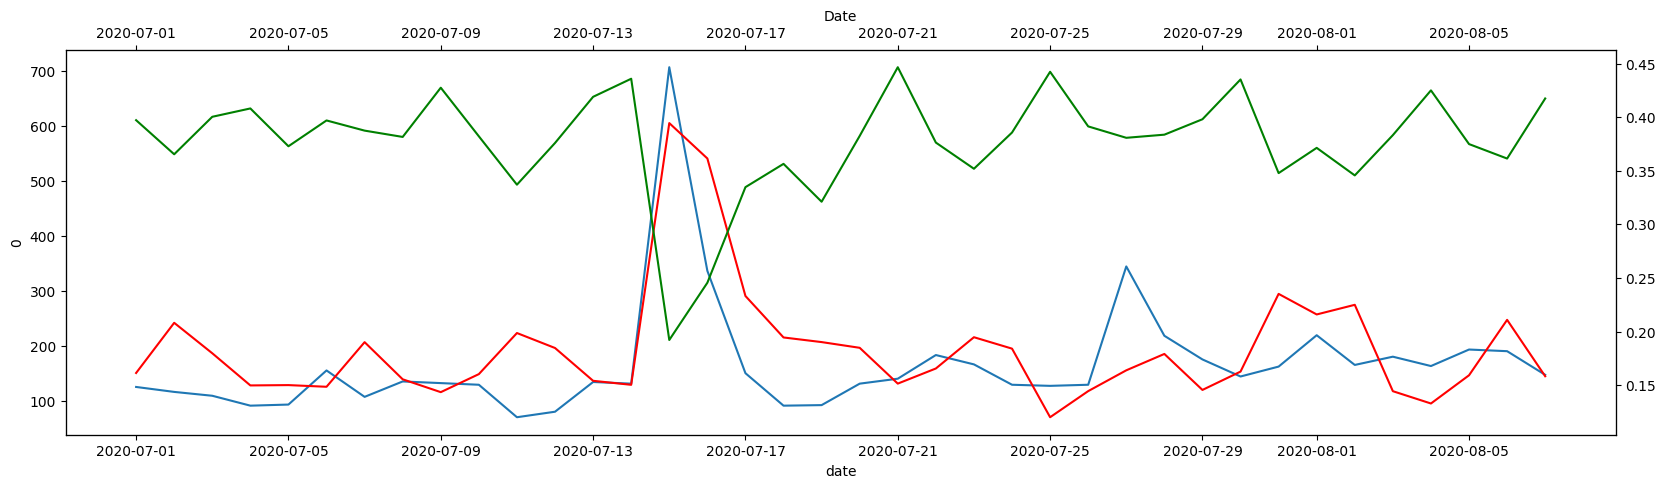

In [269]:
date = []
for i in range(38):
    date.append(pd.to_datetime('2020-07-01') + pd.Timedelta(days=i))

dff['date'] = date
fig = plt.figure(figsize=(20, 5))
ax = sns.lineplot(x='date', y='0', data=dff)
ax2 = ax.twinx()
ax3 = ax2.twiny()
ax2 = sns.lineplot(x='Date', y='roberta_neg', data=btc_df1, color='r')
ax3 = sns.lineplot(x='Date', y='roberta_pos', data=btc_df1, color='g')

plt.show()

## Ethereum

In [270]:
eth_df = pd.read_csv(f'ETH_Tweets.csv', index_col=0)

In [271]:
eth_df.head()

,Date,Retweet,Reply,Likes,Tweet
0,2020-07-01 23:00:05+00:00,318,43,2098,💻 Two new teasers have dropped in #ApexLegends...
1,2020-07-01 12:33:03+00:00,2195,917,1681,I will give someone $150 in 24hours all you ha...
2,2020-07-01 11:33:16+00:00,207,6,1245,31 Days of Apex: Memory\nCrypto's forever fami...
3,2020-07-01 20:02:49+00:00,417,75,1223,#Blockchain technology and #XRP play a fundame...
4,2020-07-01 15:03:23+00:00,1395,310,1150,Calling all blockchain game enthusiasts: we ar...


In [272]:
roberta_result = {}
classes = []
for i, row in tqdm(eth_df.iterrows(), total=len(eth_df)):
    text = row['Tweet']
    result = polarity_scores_roberta(text)
    roberta_result[i] = {**result[0]}
    classes.append(result[1])

100%|██████████| 3379/3379 [06:37<00:00,  8.50it/s]


In [273]:
eth_df = eth_df.join(pd.DataFrame(roberta_result).T)
eth_df['classes'] = classes

In [274]:
eth_df.head()

,Date,Retweet,Reply,Likes,Tweet,roberta_neg,roberta_neu,roberta_pos,classes
0,2020-07-01 23:00:05+00:00,318,43,2098,💻 Two new teasers have dropped in #ApexLegends...,0.091743,0.844816,0.063441,0
1,2020-07-01 12:33:03+00:00,2195,917,1681,I will give someone $150 in 24hours all you ha...,0.001092,0.040329,0.958579,1
2,2020-07-01 11:33:16+00:00,207,6,1245,31 Days of Apex: Memory\nCrypto's forever fami...,0.023992,0.801558,0.174450,0
3,2020-07-01 20:02:49+00:00,417,75,1223,#Blockchain technology and #XRP play a fundame...,0.008470,0.540194,0.451336,0
4,2020-07-01 15:03:23+00:00,1395,310,1150,Calling all blockchain game enthusiasts: we ar...,0.000847,0.032527,0.966626,1


In [275]:
eth_df.to_csv('sentiment_eth.csv')

In [276]:
eth_df['Date'] = pd.to_datetime(eth_df['Date']).dt.date
eth_df1 = eth_df.groupby('Date')[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()

In [277]:
dff = pd.read_csv(r'ETH_tweet_perday.csv', index_col=0)

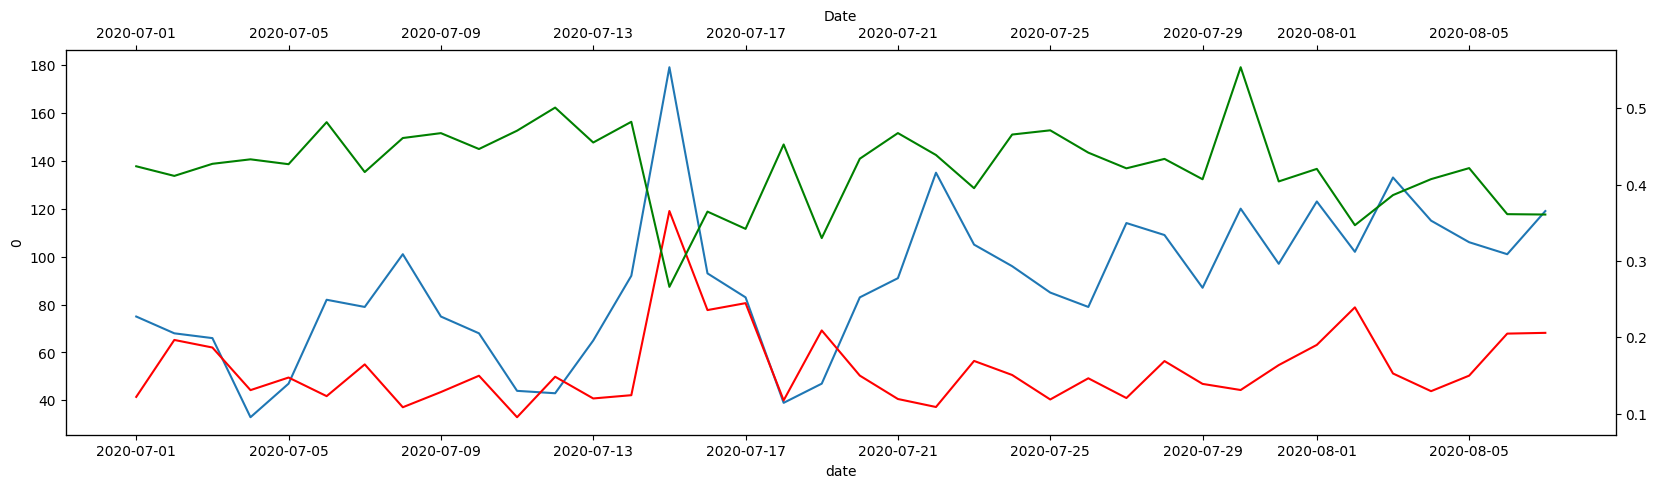

In [278]:
date = []
for i in range(38):
    date.append(pd.to_datetime('2020-07-01') + pd.Timedelta(days=i))

dff['date'] = date
fig = plt.figure(figsize=(20, 5))
ax = sns.lineplot(x='date', y='0', data=dff)
ax2 = ax.twinx()
ax3 = ax2.twiny()
ax2 = sns.lineplot(x='Date', y='roberta_neg', data=eth_df1, color='r')
ax3 = sns.lineplot(x='Date', y='roberta_pos', data=eth_df1, color='g')

plt.show()